## Warning: If CUDA is available, use CPU instead of GPU
Overhead of GPU makes training this small model very slow, force keras to use the CPU instead.

Run the below cell before anything else:

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Now, try running the imports

In [2]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Dot
import tensorflow.keras.backend as K

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2393079330346199654
xla_global_id: -1
]


## Only proceed if no GPU device is shown in the above cell

In [4]:
train_df = pd.read_pickle('Speaker_Classification_data/train.df')
test_df = pd.read_pickle('Speaker_Classification_data/test.df')

In [5]:
train_df.head()

,inputA,inputB,label
0,"[0.6259576307297445, 0.40422018505075, 0.33808...","[0.8785945881900982, 0.04003334094116476, 0.18...",1
1,"[0.512732250501038, 0.41837384487043455, 0.459...","[0.5508735478037253, 0.35679966623366144, 0.40...",1
2,"[0.5705212932258709, 0.40447019253630095, 0.57...","[0.5002341964855943, 0.44852124181224495, 0.70...",1
3,"[0.6716892570459904, 0.2568239174356624, 0.465...","[0.3180312526532941, 0.5282743435568443, 0.729...",0
4,"[0.4092282572898532, 0.6629626243964712, 0.771...","[0.4472490363914092, 0.7145415799053311, 0.654...",1


In [6]:
test_df.head()

,inputA,inputB,label
0,"[0.5142333013044343, 1.0, 0.528514533012731, 0...","[0.5838474859123154, 0.737866278911825, 0.6344...",1
1,"[0.9184059557245976, 0.2592263926049499, 0.368...","[0.439322194783416, 0.6883048330484197, 0.7197...",1
2,"[0.20991285946164542, 0.5907850984592853, 0.77...","[0.4313755682924979, 0.4552303973251103, 0.689...",0
3,"[0.38706602283265934, 0.3531728127170686, 0.76...","[0.464291056204104, 0.307338873764661, 0.57590...",1
4,"[0.5765927650414007, 0.2964150457391947, 0.518...","[0.5946977418212969, 0.2639801834168179, 0.549...",1


## Defining and training model

In [6]:
def build_siamese_model(inputsize, nlayers=2, nsize=64, emb_dim=100):
    inputs = Input(inputsize)
    x = Dense(nsize, activation='relu')(inputs)
    x = Dropout(0.1)(x)
    for _ in range(nlayers-1):
        x = Dense(nsize, activation='relu')(x)
        x = Dropout(0.1)(x)
    outputs = Dense(emb_dim)(x)
    model = Model(inputs, outputs)
    
    return model

In [8]:
# building model
input_shape = len(train_df['inputA'][0])
inputA = Input(input_shape)
inputB = Input(input_shape)
featureExtractor = build_siamese_model(input_shape)
featsA = featureExtractor(inputA)
featsB = featureExtractor(inputB)

output_cos = Dot(axes=1, normalize=True)([featsA, featsB])
model = Model(inputs=[inputA, inputB], outputs=output_cos)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 175)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 175)]        0           []                               
                                                                                                  
 model (Functional)             (None, 100)          21924       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dot (Dot)                      (None, 1)            0           ['model[0][0]',            

In [10]:
X1_train = np.asarray(list(train_df['inputA']), dtype=np.float32)
X2_train = np.asarray(list(train_df['inputB']), dtype=np.float32)

X1_test = np.asarray(list(test_df['inputA']), dtype=np.float32)
X2_test = np.asarray(list(test_df['inputB']), dtype=np.float32)

In [11]:
history = model.fit([X1_train, X2_train], train_df['label'],
          validation_data=([X1_test, X2_test], test_df['label']),
          batch_size=1, epochs=50, verbose=2)

Epoch 1/50
59471/59471 - 78s - loss: 0.5875 - accuracy: 0.7300 - val_loss: 0.3990 - val_accuracy: 0.8433 - 78s/epoch - 1ms/step
Epoch 2/50
59471/59471 - 69s - loss: 0.4136 - accuracy: 0.8275 - val_loss: 0.3349 - val_accuracy: 0.8839 - 69s/epoch - 1ms/step
Epoch 3/50
59471/59471 - 66s - loss: 0.3216 - accuracy: 0.8761 - val_loss: 0.2694 - val_accuracy: 0.9042 - 66s/epoch - 1ms/step
Epoch 4/50
59471/59471 - 70s - loss: 0.2784 - accuracy: 0.8971 - val_loss: 0.2145 - val_accuracy: 0.9247 - 70s/epoch - 1ms/step
Epoch 5/50
59471/59471 - 69s - loss: 0.2489 - accuracy: 0.9098 - val_loss: 0.2342 - val_accuracy: 0.9153 - 69s/epoch - 1ms/step
Epoch 6/50
59471/59471 - 68s - loss: 0.2378 - accuracy: 0.9153 - val_loss: 0.2291 - val_accuracy: 0.9159 - 68s/epoch - 1ms/step
Epoch 7/50
59471/59471 - 73s - loss: 0.2190 - accuracy: 0.9230 - val_loss: 0.1778 - val_accuracy: 0.9390 - 73s/epoch - 1ms/step
Epoch 8/50
59471/59471 - 69s - loss: 0.2160 - accuracy: 0.9250 - val_loss: 0.1684 - val_accuracy: 0.9428

In [12]:
def plot_from_history(hist, metric='accuracy', label='Training and Test accuracy', save_path=""):
    plt.figure()
    plt.plot(range(1, 51), hist[metric], 'orange', label='Training '+metric)
    plt.plot(range(1, 51), hist["val_"+metric], 'blue', label='Test '+metric)
    plt.title(label)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    if len(save_path):
        plt.savefig(save_path)
    plt.show()

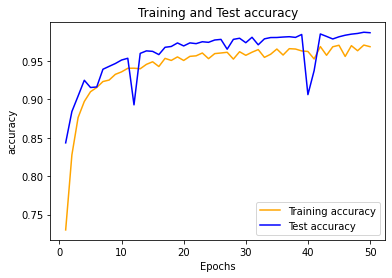

In [13]:
plot_from_history(history.history)

In [14]:
model.save("./models/new_siamese_175")

INFO:tensorflow:Assets written to: ./models/base_siamese_175\assets


## Loading and testing best model

In [7]:
model = keras.models.load_model("./models/base_siamese_175")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 175)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 175)]        0           []                               
                                                                                                  
 model (Functional)             (None, 100)          21924       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dot (Dot)                      (None, 1)            0           ['model[0][0]',            

In [8]:
model.predict([np.array([train_df['inputA'][0]]), np.array([train_df['inputB'][0]])])[0][0]

0.99954754

In [9]:
model.predict([np.array(list(train_df['inputA'])), np.array(list(train_df['inputB']))])

array([[ 0.99954754],
       [ 0.784888  ],
       [ 0.93954587],
       ...,
       [-0.0120241 ],
       [ 0.9998923 ],
       [-0.01533243]], dtype=float32)

In [10]:
start = time.time()
preds = [x[0] for x in model.predict([np.array(list(train_df['inputA'])), np.array(list(train_df['inputB']))])]
end = time.time()
train_results = train_df.copy()
train_results['preds'] = preds
print("Done in:", (end-start), "seconds")
print("Average time per pred:", ((end-start)/len(train_df)), "seconds")
train_results.head()

Done in: 1.4191858768463135 seconds
Average time per pred: 2.3863494423270393e-05 seconds


,inputA,inputB,label,preds
0,"[0.6259576307297445, 0.40422018505075, 0.33808...","[0.8785945881900982, 0.04003334094116476, 0.18...",1,0.999548
1,"[0.512732250501038, 0.41837384487043455, 0.459...","[0.5508735478037253, 0.35679966623366144, 0.40...",1,0.784888
2,"[0.5705212932258709, 0.40447019253630095, 0.57...","[0.5002341964855943, 0.44852124181224495, 0.70...",1,0.939546
3,"[0.6716892570459904, 0.2568239174356624, 0.465...","[0.3180312526532941, 0.5282743435568443, 0.729...",0,-0.044265
4,"[0.4092282572898532, 0.6629626243964712, 0.771...","[0.4472490363914092, 0.7145415799053311, 0.654...",1,0.846460


<AxesSubplot:title={'center':'preds'}, xlabel='label'>

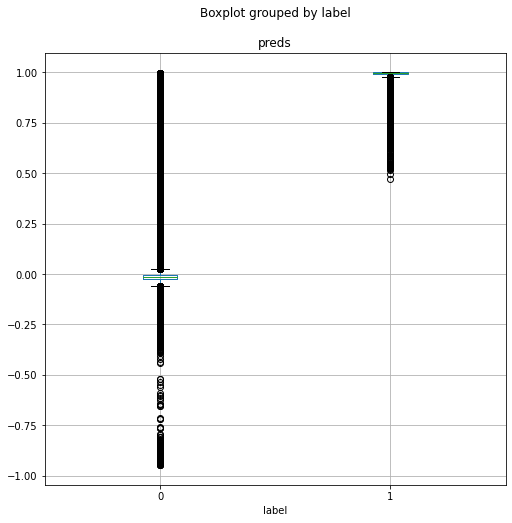

In [11]:
train_results.boxplot('preds', 'label', figsize=(8,8))

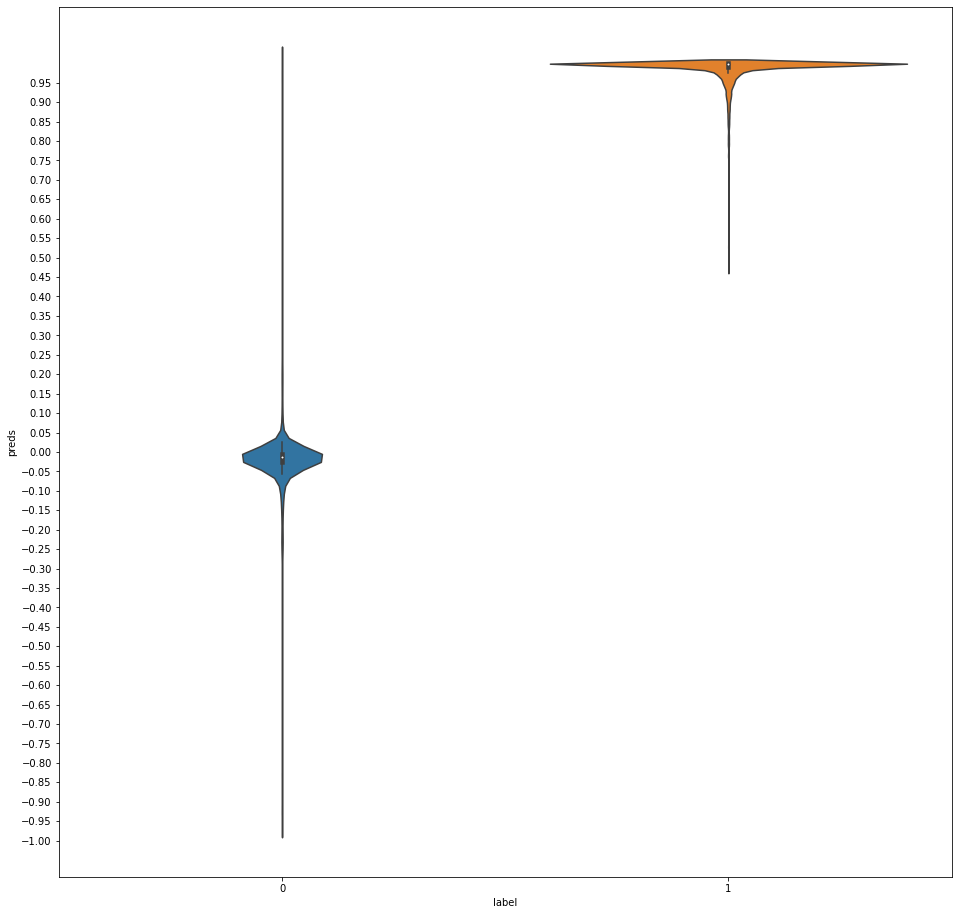

In [12]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.violinplot(ax=ax, x="label", y="preds", data=train_results)
ax.set_yticks([-1+0.05*x for x in range(40)])

In [13]:
threshold = 0.75
train_results['pred_class'] = train_results.apply(lambda x: int(x['preds']>=threshold), axis=1)
train_results.head()

,inputA,inputB,label,preds,pred_class
0,"[0.6259576307297445, 0.40422018505075, 0.33808...","[0.8785945881900982, 0.04003334094116476, 0.18...",1,0.999548,1
1,"[0.512732250501038, 0.41837384487043455, 0.459...","[0.5508735478037253, 0.35679966623366144, 0.40...",1,0.784888,1
2,"[0.5705212932258709, 0.40447019253630095, 0.57...","[0.5002341964855943, 0.44852124181224495, 0.70...",1,0.939546,1
3,"[0.6716892570459904, 0.2568239174356624, 0.465...","[0.3180312526532941, 0.5282743435568443, 0.729...",0,-0.044265,0
4,"[0.4092282572898532, 0.6629626243964712, 0.771...","[0.4472490363914092, 0.7145415799053311, 0.654...",1,0.846460,1


In [14]:
print(confusion_matrix(train_results.label, train_results.pred_class))

[[29229   450]
 [  146 29646]]


In [15]:
print(classification_report(train_results.label, train_results.pred_class))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29679
           1       0.99      1.00      0.99     29792

    accuracy                           0.99     59471
   macro avg       0.99      0.99      0.99     59471
weighted avg       0.99      0.99      0.99     59471



In [16]:
train_results.to_csv('results/siamese_train_preds.csv', index=False, columns=['label', 'preds', 'pred_class'])

In [17]:
start = time.time()
preds = [x[0] for x in model.predict([np.array(list(test_df['inputA'])), np.array(list(test_df['inputB']))])]
end = time.time()
test_results = test_df.copy()
test_results['preds'] = preds
print("Done in:", (end-start), "seconds")
print("Average time per pred:", ((end-start)/len(train_df)), "seconds")
test_results.head()

Done in: 0.6162338256835938 seconds
Average time per pred: 1.0361921368122173e-05 seconds


,inputA,inputB,label,preds
0,"[0.5142333013044343, 1.0, 0.528514533012731, 0...","[0.5838474859123154, 0.737866278911825, 0.6344...",1,0.994371
1,"[0.9184059557245976, 0.2592263926049499, 0.368...","[0.439322194783416, 0.6883048330484197, 0.7197...",1,0.998511
2,"[0.20991285946164542, 0.5907850984592853, 0.77...","[0.4313755682924979, 0.4552303973251103, 0.689...",0,0.831328
3,"[0.38706602283265934, 0.3531728127170686, 0.76...","[0.464291056204104, 0.307338873764661, 0.57590...",1,0.999972
4,"[0.5765927650414007, 0.2964150457391947, 0.518...","[0.5946977418212969, 0.2639801834168179, 0.549...",1,0.999818


In [18]:
threshold = 0.75
test_results['pred_class'] = test_results.apply(lambda x: int(x['preds']>=threshold), axis=1)
test_results.head()

,inputA,inputB,label,preds,pred_class
0,"[0.5142333013044343, 1.0, 0.528514533012731, 0...","[0.5838474859123154, 0.737866278911825, 0.6344...",1,0.994371,1
1,"[0.9184059557245976, 0.2592263926049499, 0.368...","[0.439322194783416, 0.6883048330484197, 0.7197...",1,0.998511,1
2,"[0.20991285946164542, 0.5907850984592853, 0.77...","[0.4313755682924979, 0.4552303973251103, 0.689...",0,0.831328,1
3,"[0.38706602283265934, 0.3531728127170686, 0.76...","[0.464291056204104, 0.307338873764661, 0.57590...",1,0.999972,1
4,"[0.5765927650414007, 0.2964150457391947, 0.518...","[0.5946977418212969, 0.2639801834168179, 0.549...",1,0.999818,1


In [19]:
print(confusion_matrix(test_results.label, test_results.pred_class))

[[12619   182]
 [   71 12616]]


In [20]:
print(classification_report(test_results.label, test_results.pred_class))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12801
           1       0.99      0.99      0.99     12687

    accuracy                           0.99     25488
   macro avg       0.99      0.99      0.99     25488
weighted avg       0.99      0.99      0.99     25488



In [21]:
test_results.to_csv('results/siamese_test_preds.csv', index=False, columns=['label', 'preds', 'pred_class'])